# Lab Report
*Jakub Skalski, 314007*

#### Neyman polynomials

In [1]:
library("orthopolynom")

polynomials = legendre.polynomials(n=12, normalized=TRUE)

legpoly = function(sample, k) {
	# observation x polynomial
	P = head(polynomials, k+1)
	B = do.call(cbind, polynomial.values(polynomials=P, 2*sample-1))
	B = sqrt(2)*B[, 2:ncol(B)]
	return(as.matrix(B))
}

neyman = function (sample, k) {
	B = legpoly(sample, k)
	n = length(sample)
	sum((colSums(B)^2)/n)
}

#### Test statistics

In [2]:
search = function(f, K = 12) {
	statistics = sapply(1:K, f)
	which.max(statistics)
}

Schawrz = function(sample) search(function(k) neyman(sample, k) - k*log(length(sample)))

Akaike = function(sample) search(function(k) neyman(sample, k) - 2*k)

T = function(sample, K = 12) {
	II = function(k, n, c = 2.4) {
		B = legpoly(sample, K)
		M = max(abs(colSums(B)) / sqrt(n))
		sq = sqrt(c*log(n))
		L = k*log(n) * (M <= sq)
		R = 2*k * (M > sq)
		return(L + R)
	}

	search(function(k) neyman(sample, k) - II(k, length(sample)))
}

Ns = function(sample) neyman(sample, Schawrz(sample))
Na = function(sample) neyman(sample, Akaike(sample))
Nt = function(sample) neyman(sample, T(sample))

#### Experiment setup

In [3]:
identity = function(x, ...) x

critical.values = function(tests, ...) c(
	critical = as.numeric(quantile(tests, 0.95))
)

do.experiment = function (times = 1e4, sampler = runif, n = 10, aggregate = identity) {
	sample = function(test, ...) {
		args = list(...)
		replicate(times, do.call(test, append(list(sampler(n)), args)))
	}

	N1 = aggregate(sample(neyman,  k=1), q = qchisq(0.95, 1))
	N4 = aggregate(sample(neyman,  k=4), q = qchisq(0.95, 4))
	N8 = aggregate(sample(neyman,  k=8), q = qchisq(0.95, 8))
	Ns = aggregate(sample(Ns),			 q = qchisq(0.95, 1))
	Na = aggregate(sample(Na),			 q = 14.3376		)
	Nt = aggregate(sample(Nt),			 q = qchisq(0.95, 1))

	data.frame(N1, N4, N8, Ns, Na, Nt)
}

compare = function(..., variables = list()) {
	metric = function (vs) {
		result = do.call(do.experiment, append(unlist(vs), list(...)))
		tryCatch(setNames(as.numeric(result), names(result)), error = function(e) result)
	}
	metrics = sapply(variables, metric)
	data.frame(metrics)
}

series = function(..., range = 20:100, by = "n") {
	namedpair = function(value) {
		pair = c(value)
		names(pair) = by
		return(pair)
	}

	df = compare(..., variables = lapply(range, namedpair))
	colnames(df) = range
	return(df)
}

plot.series = function(series, title = "Power Functions") {
	options(repr.plot.width=18, repr.plot.height=6)
	palette(c("#7ad151", "#22a884", "#2a788e", "#414487", "#E6AB02", "darkred"))
	matplot(colnames(series), t(series), type="l", main = title, lty=1, lwd=3, ylab = "value", xlab = "n")
	legend("topleft", legend = rownames(series), col = 1:nrow(series), lty=1, lwd=3)
}

plot.hist = function(x, density=NA, title="") {
	hist(x, density=20, breaks=200, prob=TRUE, main=title, ylab="density")
	if(is.function(density)) curve(density(x), col="darkred", lwd=3, add=TRUE)
}

# Exercise 1

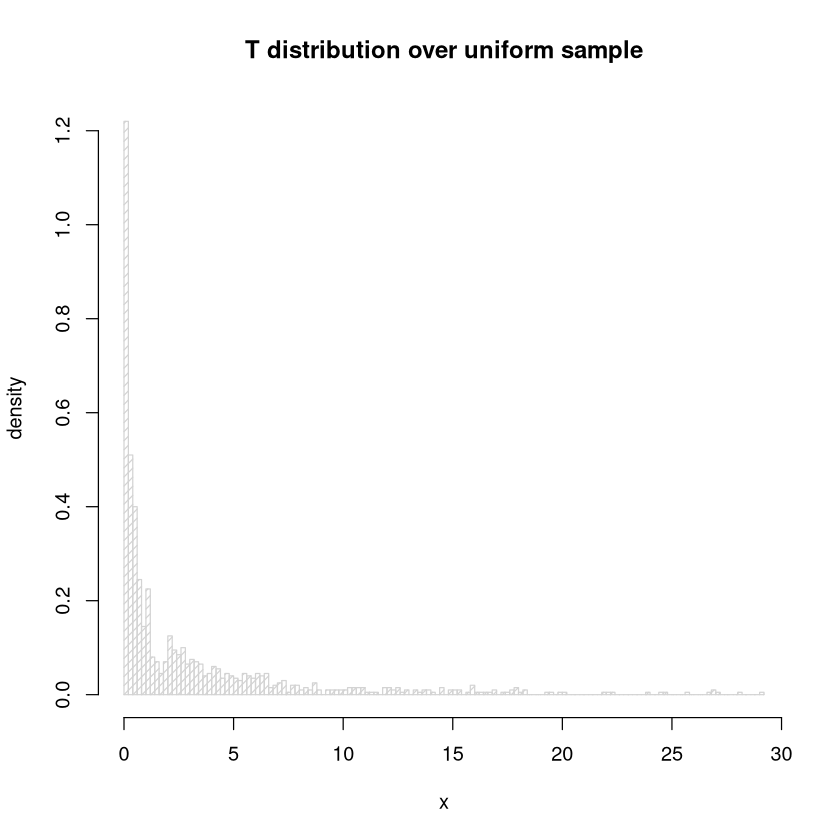

In [4]:
plot.hist(replicate(1000, Na(runif(1000))), title="T distribution over uniform sample")

In [5]:
quantiles = c(qchisq(0.95, 1), qchisq(0.95, 4), qchisq(0.95, 8), qchisq(0.95, 1), NA, qchisq(0.95, 1))

print(rbind(
	do.experiment(n = 20, times=1e4, aggregate = critical.values),
	quantile = quantiles
))

print(rbind(
	do.experiment(n = 1000, times=1e4, aggregate = critical.values),
	quantile = quantiles
))

               N1       N4       N8       Ns       Na        Nt
critical 3.840067 9.482439 15.85276 7.923497 15.47142 11.089167
quantile 3.841459 9.487729 15.50731 3.841459       NA  3.841459
               N1       N4       N8       Ns       Na       Nt
critical 3.776724 9.314292 15.58946 4.033879 14.42991 4.192495
quantile 3.841459 9.487729 15.50731 3.841459       NA 3.841459


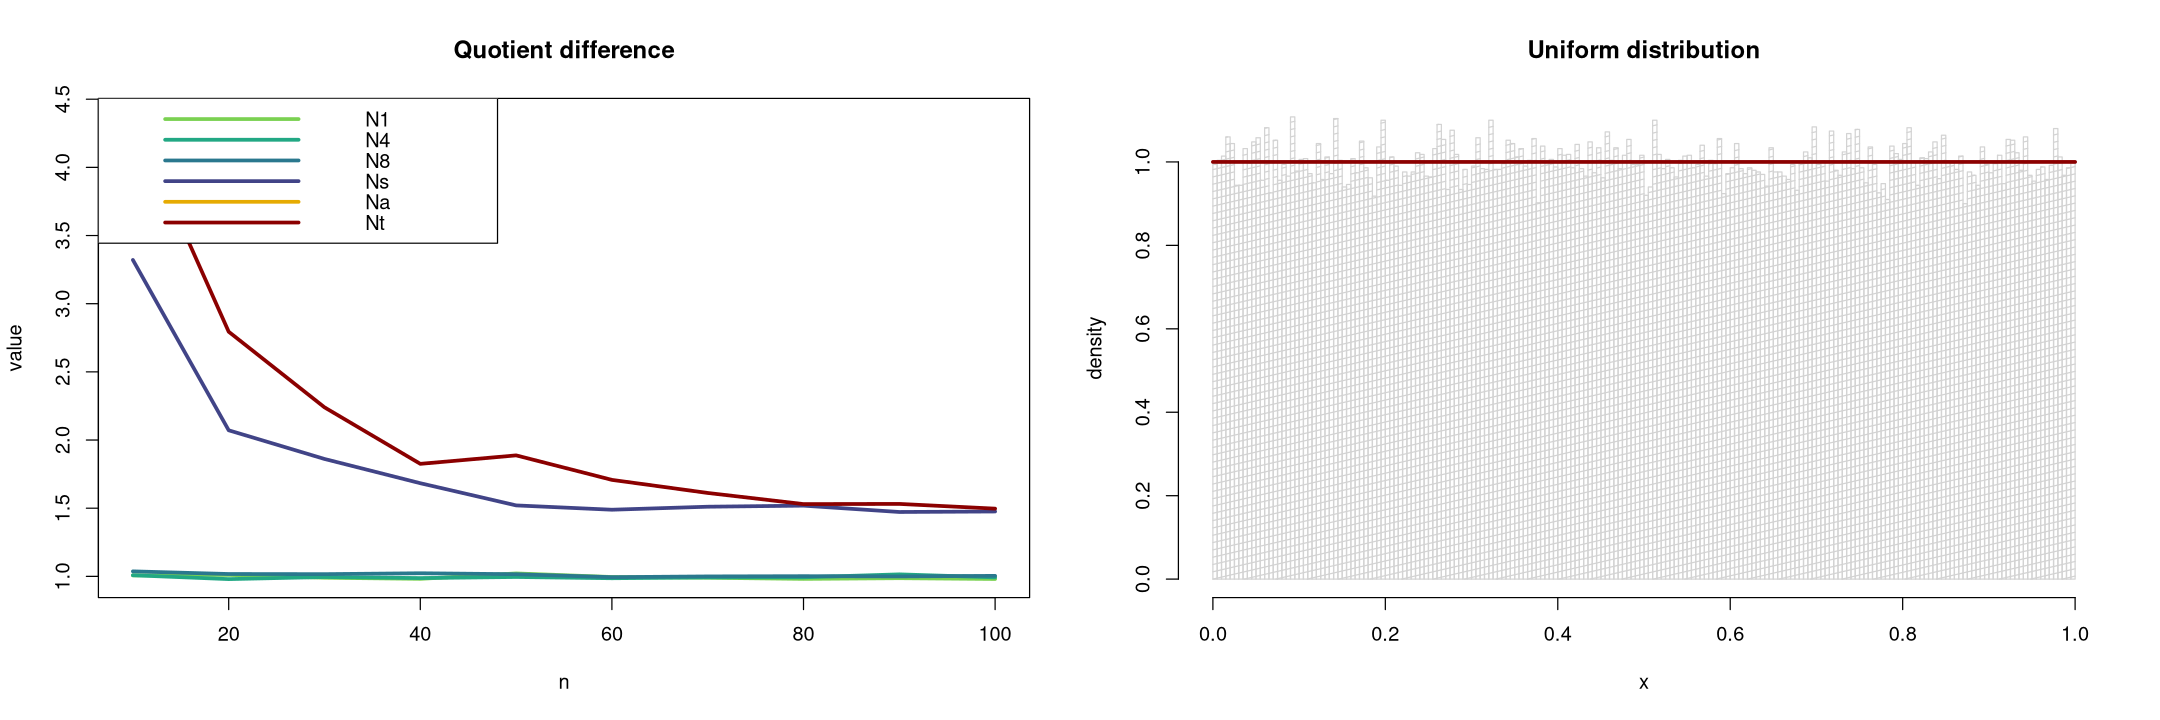

In [6]:
par(mfrow = c(1, 2))
plot.series(
	# the closer to 1.0 the better
	series(times=1e4, aggregate=critical.values, range=seq(10,100,10)) / quantiles,
	title = "Quotient difference"
)
plot.hist(runif(100000), dunif, "Uniform distribution")

Convergence rate is slower for the introduced test statistics, but as can be seen for the sample size of 1000 they approach the quantiles of their respective limiting distributions (Na is not considered here).

# Exercise 3

In [1]:
qC = function(j, p) function(u) 1 + p*cos(j*pi*u)

rC = function(n, j, p) {
	# accept-reject von Neumann algorithm
	M = 1 + p
	population = list()
	repeat {
		len = length(population)
		if (len == n) break
		x = runif(n - len)
		u = runif(n - len)
		population = append(population, x[u <= qC(j, p)(x) / M])
	}
	return(as.numeric(population))
}

C = function(j, p) function(n) rC(n, j, p)

In [8]:
pwr = function(values, q) c(power = sum(values > q) / length(values))

In [9]:
plot.experiment = function (j, p) {
	par(mfrow = c(1, 2))
	plot.series(series(times=1e4, aggregate=pwr, sampler=C(j, p), range=seq(10, 100, 10)))
	plot.hist(rC(100000, j, p), qC(j, p), paste("C(", j, ", ", p, ") distribution", sep=""))
}

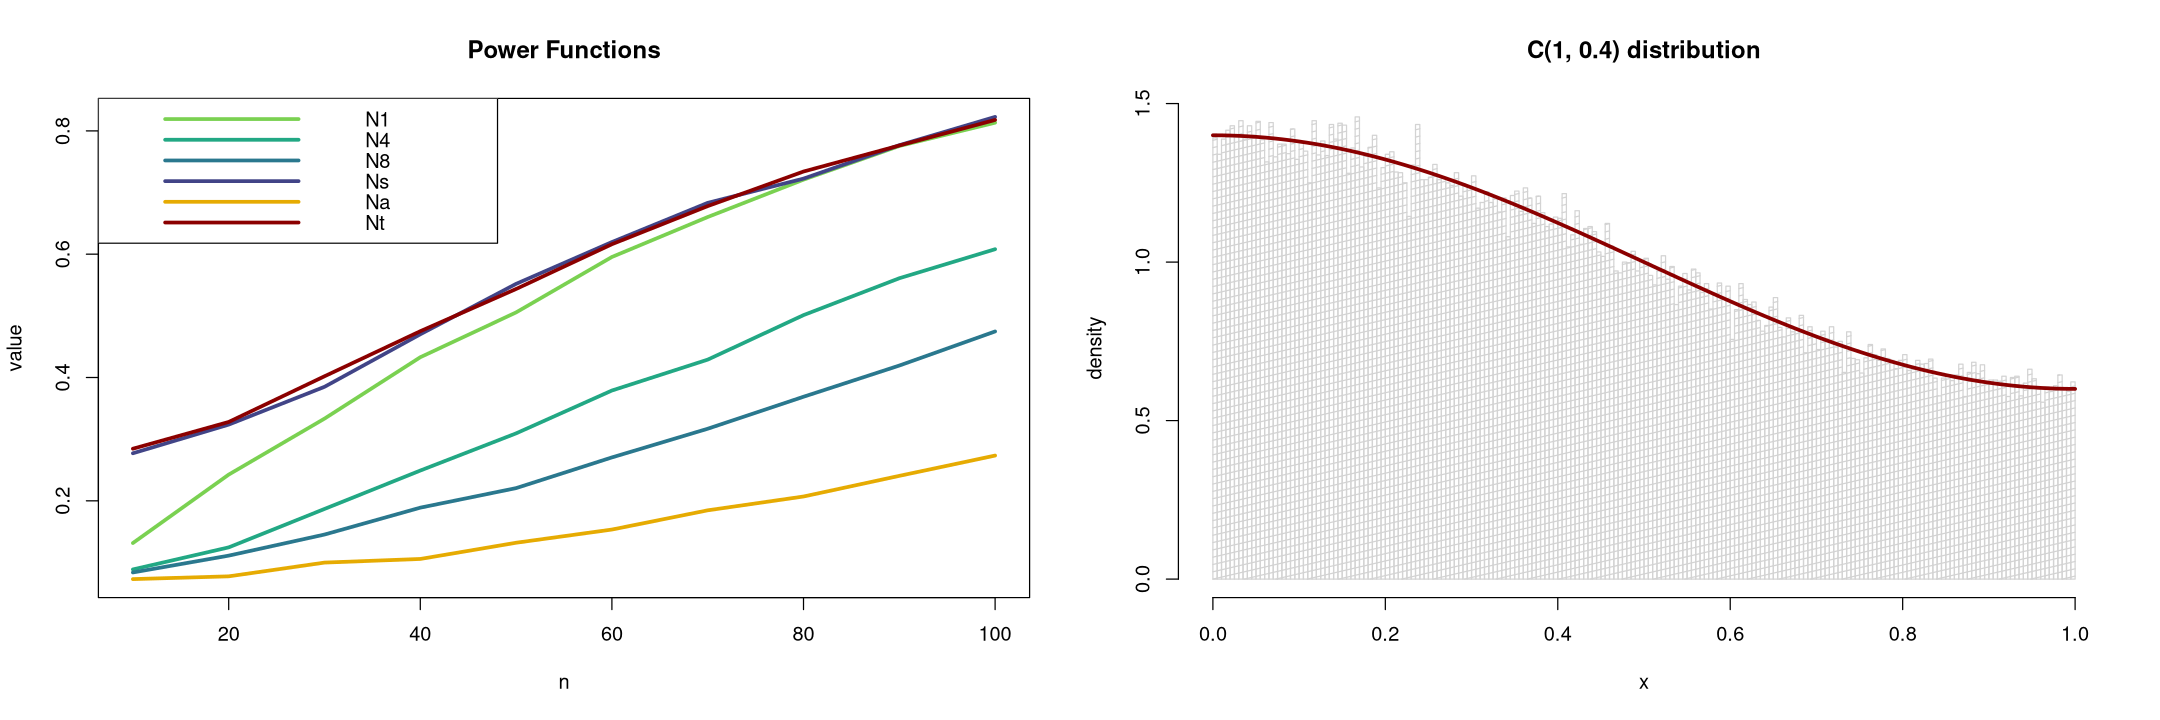

In [10]:
plot.experiment(1, 0.4)

The power of the test statistics grows almost monotonically with the sample size.
Nt and Ns are even surpassing our previous testing methods.

# Exercise 4

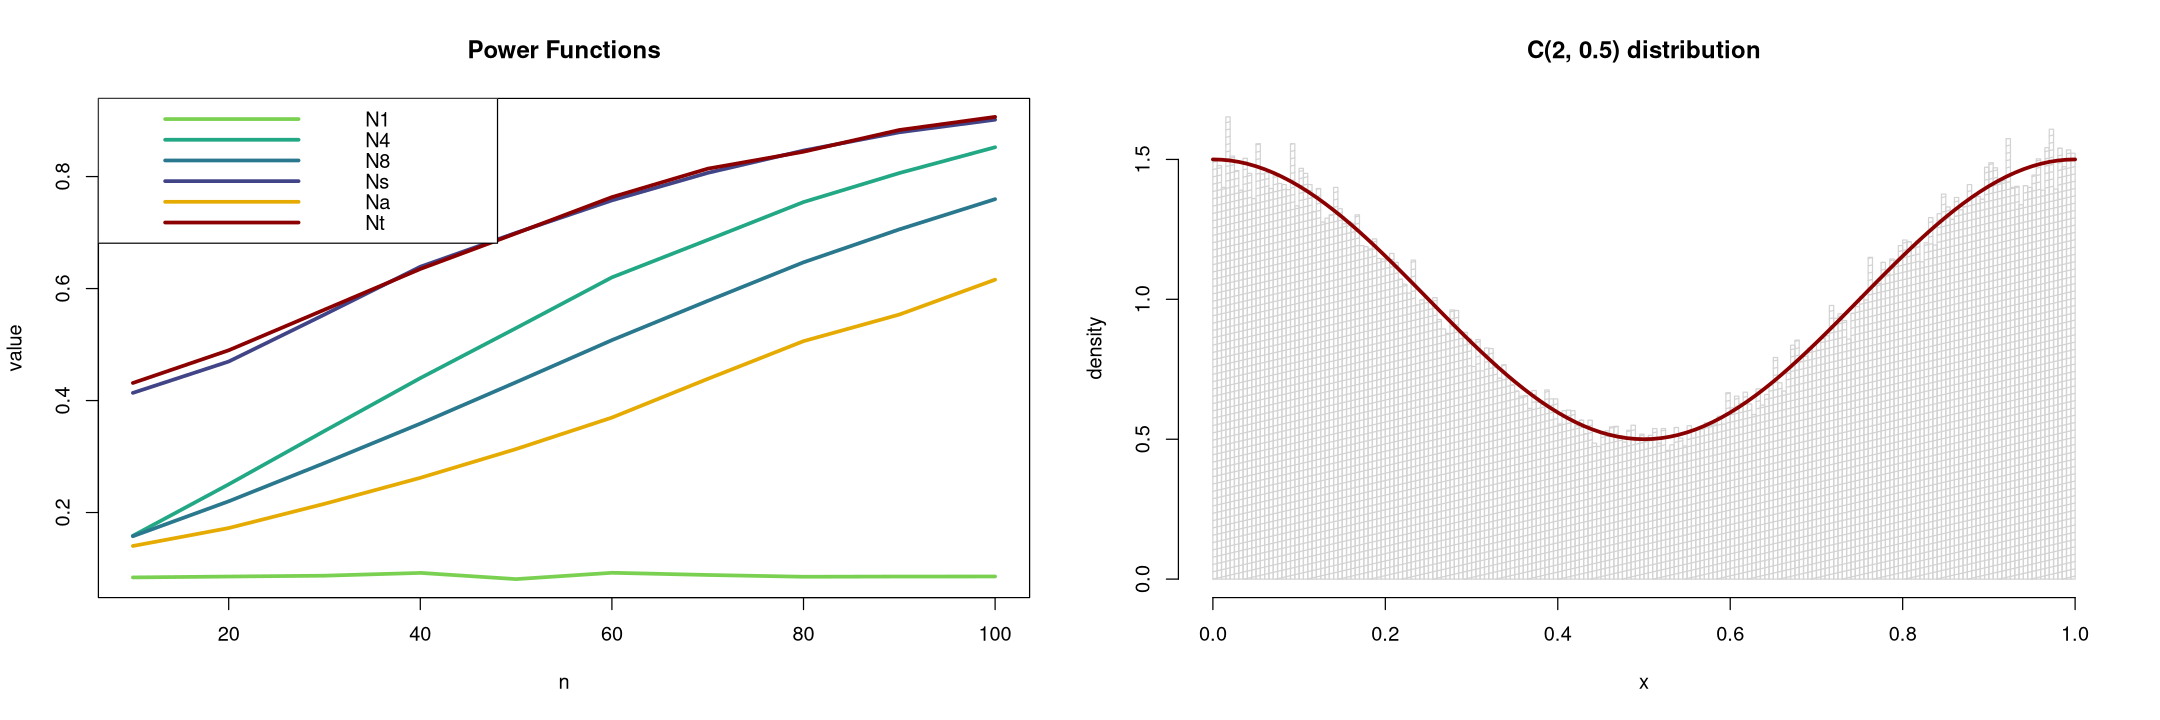

In [11]:
plot.experiment(2, 0.5)

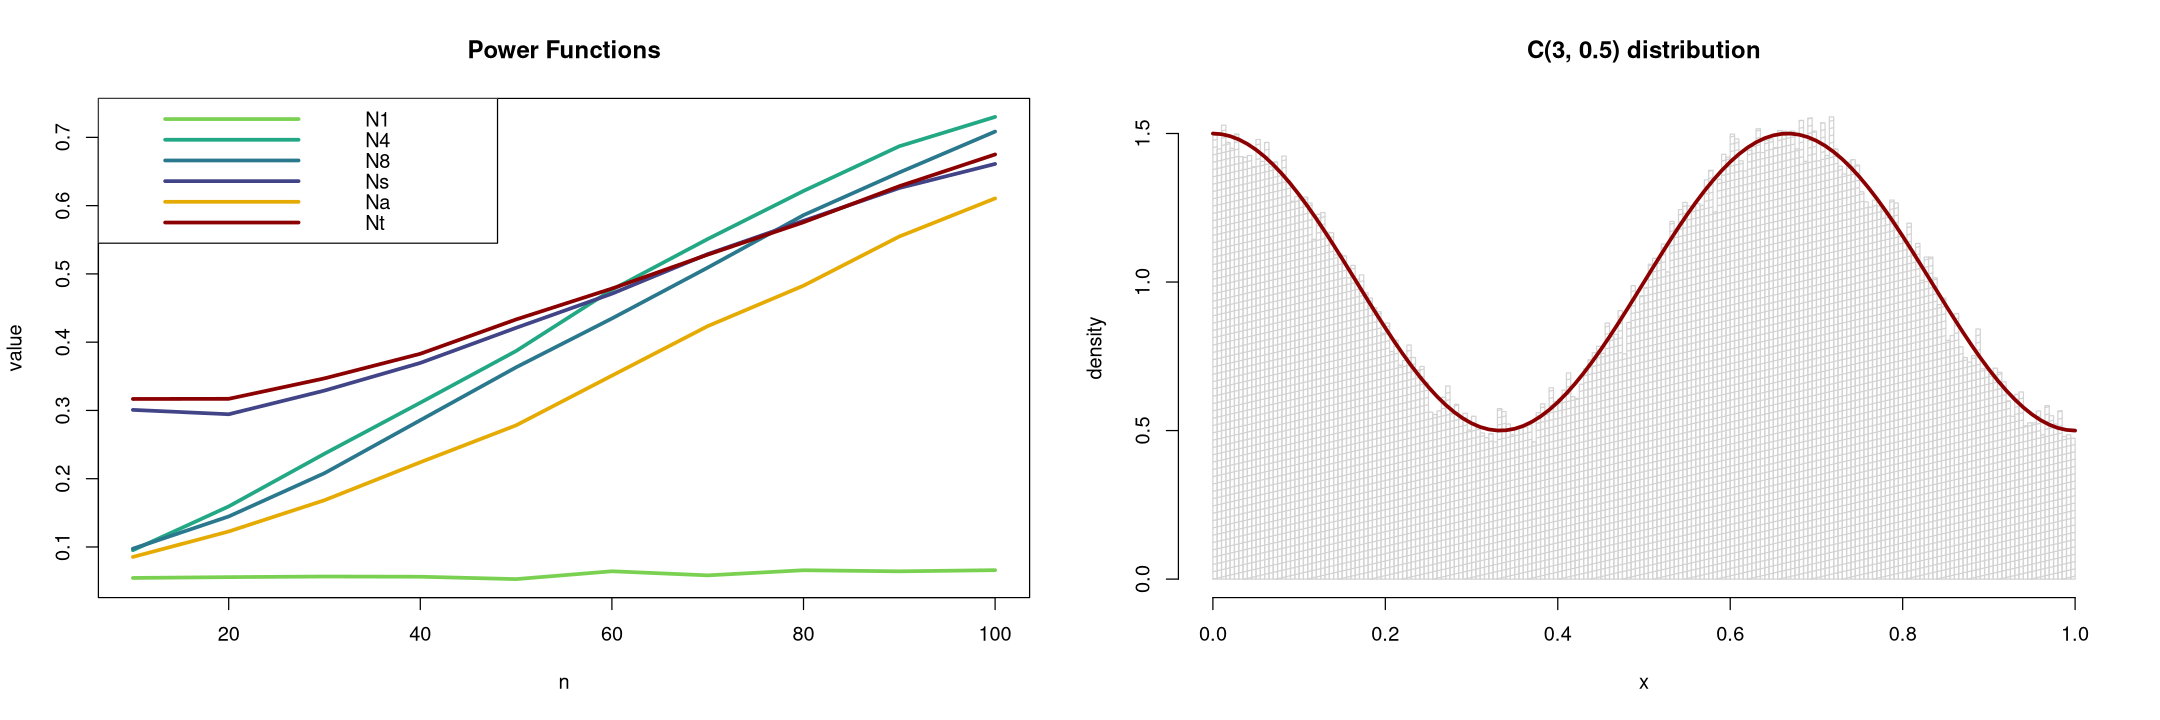

In [12]:
plot.experiment(3, 0.5)

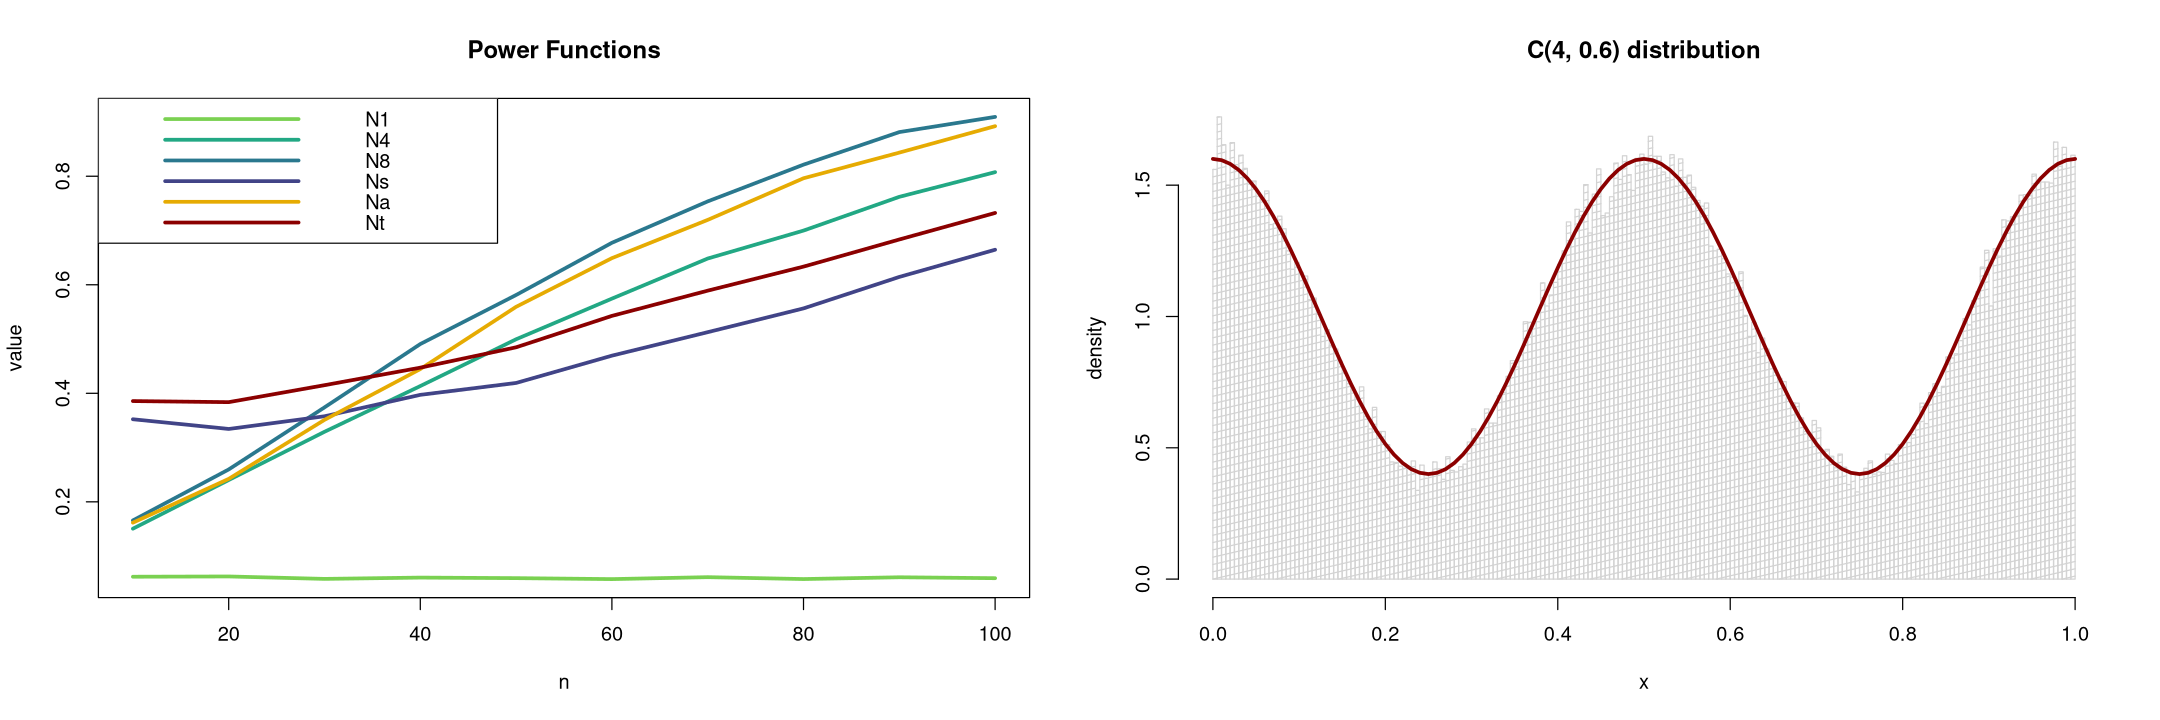

In [13]:
plot.experiment(4, 0.6)

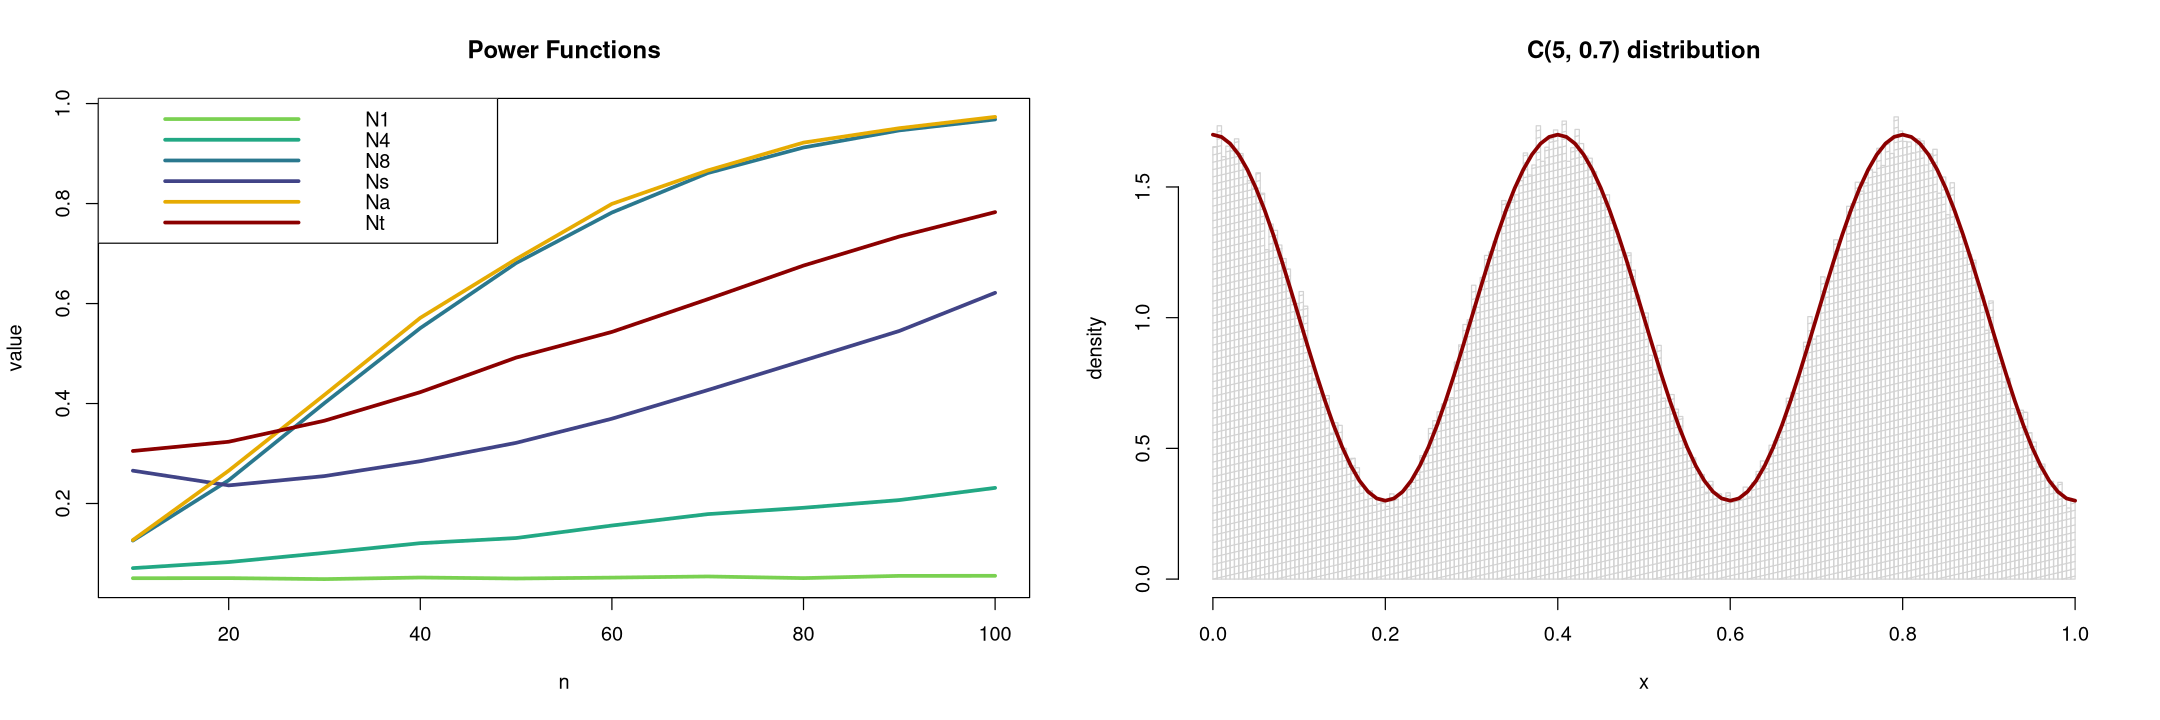

In [14]:
plot.experiment(5, 0.7)

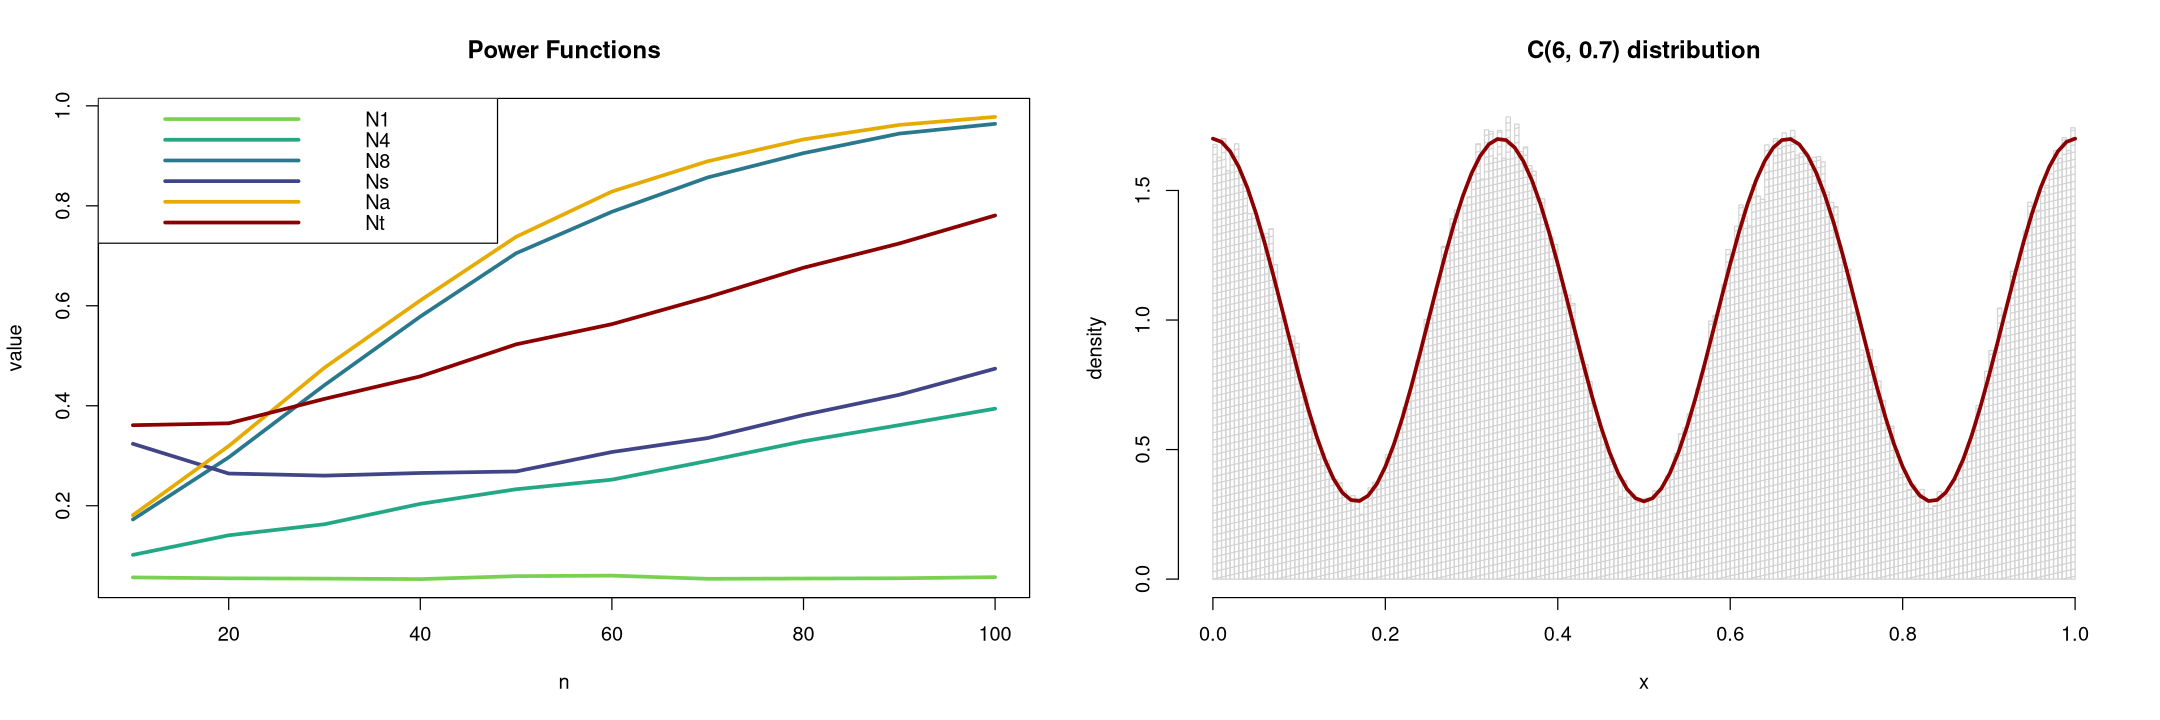

In [15]:
plot.experiment(6, 0.7)

This comparison shows how the power of the Akaike and Schawrz tests relates to the underlying distribution's shape.
Notice how Akaike struggles with the smoother curves while Schawrz on the other hand excels at them.
We can also observe our T statistic found its place in the middle of the other two presumably meaning we can expect it to be more consistent and thus also more reliable. 